In [1]:
# import
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import random
import torch.nn as nn
import torch.nn.functional as F
import warnings
import datetime
from copy import deepcopy

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(777)

In [3]:
sns.set()
plt.rcParams['figure.figsize'] = (24, 18)        
plt.rcParams['image.interpolation'] = 'nearest'  
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
num = 500
dz = 5




dataset_x=torch.randn((num,dz))
U=np.random.binomial(n=1,p=0.5,size=num).reshape(num,1) 
U=torch.from_numpy(U)
rv_epsilon=np.zeros(shape=(num,1))
for i in range(0,len(U)):
    if U[i]<0.5:
        rv_epsilon[i]=np.random.normal(-2,1)
    else:
        rv_epsilon[i]=np.random.normal(2,1)
rv_epsilon=torch.from_numpy(rv_epsilon)
        
dataset_y=(5+dataset_x[:,0:1]**2/3+dataset_x[:,1:2]**2+dataset_x[:,2:3]**2+
           dataset_x[:,3:4]+dataset_x[:,4:5])*torch.exp(0.5*rv_epsilon)





device = torch.device('cuda')
dataset_y=dataset_y.float().to(device)
dataset_x=dataset_x.float().to(device)

# sns.kdeplot(data=dataset_y)
mean = dataset_y.mean()
std = dataset_y.std()
dataset_y = (dataset_y-mean)/std

In [4]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalGuidedModel(nn.Module):
    def __init__(self, num_steps):
        super().__init__()
        self.lin1 = ConditionalLinear(dz+1, 16, num_steps)
        self.lin2 = ConditionalLinear(16, 16, num_steps)
        self.lin3 = ConditionalLinear(16, 16, num_steps)
        self.lin4 = nn.Linear(16, 1)

    def forward(self, x, y_t, t):
        eps_pred = torch.cat((x, y_t,), dim=1)
        eps_pred = F.softplus(self.lin1(eps_pred, t))
        eps_pred = F.softplus(self.lin2(eps_pred, t))
        eps_pred = F.softplus(self.lin3(eps_pred, t))
        return self.lin4(eps_pred)

In [5]:
num_steps=1000 
def score_loss_fn(model, y_0, x, n_steps,device):
    batch_size = y_0.shape[0]
    t = torch.randint(1, n_steps, size=(batch_size,), device=device) # t_min=1/n_step
    t_input = t.unsqueeze(-1)  # priorly set T=1000/100=10
    t_compute=t.unsqueeze(-1) /100
    epsilon=torch.normal(0,1,(batch_size,1)).to(device)
    y_input=torch.exp(-t_compute/2)*y_0+torch.sqrt(1-torch.exp(-t_compute))*epsilon
    output = model(x, y_input, t_input.squeeze(-1))
    loss=(output+(y_input-torch.exp(-t_compute/2)*y_0)/(1-torch.exp(-t_compute))).square().mean()
    return loss

In [6]:
#train
import datetime
print('training model...')
batch_size=2048
dataloader=torch.utils.data.DataLoader(torch.cat([dataset_x,dataset_y],dim=1),batch_size=batch_size,shuffle=True)
plt.rc('text',color='blue')
model = ConditionalGuidedModel(num_steps).to(device)
lr=1e-2
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
num_epoch = 1500
loss_fn2=nn.MSELoss()
for z in range(num_epoch):
    total_loss=0
    for idx,batch in enumerate (dataloader):
        start = datetime.datetime.now()
        batch_x = batch[:,:dz]
        batch_y = batch[:,dz:]
        loss=score_loss_fn(model, batch_y, batch_x, 1000,device)
        total_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        end = datetime.datetime.now()
    if z%50==0:
        print(f'{z} epoch,use time:{end-start}, loss:{total_loss} ')

training model...
0 epoch,use time:0:00:00.456938, loss:1.3336604833602905 
50 epoch,use time:0:00:00.004000, loss:0.2686538100242615 
100 epoch,use time:0:00:00.005998, loss:0.38546761870384216 
150 epoch,use time:0:00:00.004000, loss:2.671217679977417 
200 epoch,use time:0:00:00.003997, loss:0.28899946808815 
250 epoch,use time:0:00:00.004000, loss:0.4689244031906128 
300 epoch,use time:0:00:00.003997, loss:0.2950454354286194 
350 epoch,use time:0:00:00.003996, loss:0.536479651927948 
400 epoch,use time:0:00:00.004003, loss:0.35123980045318604 
450 epoch,use time:0:00:00.003998, loss:1.0565046072006226 
500 epoch,use time:0:00:00.004000, loss:0.3319316506385803 
550 epoch,use time:0:00:00.002999, loss:0.902612030506134 
600 epoch,use time:0:00:00.004004, loss:0.31644147634506226 
650 epoch,use time:0:00:00.003999, loss:0.36923471093177795 
700 epoch,use time:0:00:00.003991, loss:1.190354347229004 
750 epoch,use time:0:00:00.004000, loss:0.26945143938064575 
800 epoch,use time:0:00:00

In [7]:
def score_sampler(model,shape,x, device,sample_steps=1000,):
    model.eval()
    tK_mins_t0=(1000-1)/100 
    delta_t=torch.tensor([tK_mins_t0/sample_steps],device=device) 
    y_k=torch.normal(0,1,(shape)).to(device)
    with torch.no_grad():
        for t in range(1,sample_steps):
            eps=torch.normal(0,(tK_mins_t0/sample_steps)**0.5,(shape)).to(device)
            t_input=torch.tensor([sample_steps-t],device=device)
            y_k=y_k+eps+delta_t*(0.5*y_k+model(x,y_k,t_input)) # t_input from 999 to 1
    return y_k

In [8]:
quantile_005=0.05
quantile_025=0.25
quantile_050=0.50
quantile_075=0.75
quantile_095=0.95
result=[]
repeat=100
num_test=500
for i in range(repeat): 
    seed_everything(i+3)
    print(i)
    z_fix=(torch.ones(num_test,dz)*torch.randn((1,dz))).to(device)
    U_fix=np.random.binomial(n=1,p=0.5,size=num_test).reshape(num_test,1) 
    U_fix=torch.from_numpy(U_fix).to(device)
    rv_epsilon_fix=torch.zeros(size=(num_test,1)).to(device)
    for i in range(0,len(U_fix)):
        if U_fix[i]<0.5:
            rv_epsilon_fix[i]=np.random.normal(-2,1)
        else:
            rv_epsilon_fix[i]=np.random.normal(2,1)

    y_fix=(5+z_fix[:,0:1]**2/3+z_fix[:,1:2]**2+z_fix[:,2:3]**2+z_fix[:,3:4]+z_fix[:,4:5])*torch.exp(0.5*rv_epsilon_fix)
    y_fix=y_fix.to(device)
    y0=score_sampler(model=model,shape=y_fix.shape,x=z_fix, device=device,sample_steps=1000,)
    y_seq=[y0]
    #MSE of quantile
    y_sorted=(mean+std*y_seq[-1]).view(-1).sort().values
    x_sorted=(y_fix).view(-1).sort().values
    mse_005=(y_sorted[round(num_test*quantile_005)]-x_sorted[round(num_test*quantile_005)])**2
    mse_025=(y_sorted[round(num_test*quantile_025)]-x_sorted[round(num_test*quantile_025)])**2
    mse_050=(y_sorted[round(num_test*quantile_050)]-x_sorted[round(num_test*quantile_050)])**2
    mse_075=(y_sorted[round(num_test*quantile_075)]-x_sorted[round(num_test*quantile_075)])**2
    mse_095=(y_sorted[round(num_test*quantile_095)]-x_sorted[round(num_test*quantile_095)])**2
    result.append((mse_005.detach(),mse_025.detach(),mse_050.detach(),mse_075.detach(),mse_095.detach(),mse_005.detach()+mse_025.detach()+mse_050.detach()+mse_075.detach()+mse_095.detach()))
    print(result[-1][-1])

    
quantile_005_mse=0
quantile_025_mse=0
quantile_050_mse=0
quantile_075_mse=0
quantile_095_mse=0
quantile_total=0
for i in result:
    quantile_005_mse+=i[0]
    quantile_025_mse+=i[1]
    quantile_050_mse+=i[2]
    quantile_075_mse+=i[3]
    quantile_095_mse+=i[4]
    quantile_total+=i[5]

print(f'result:{quantile_005_mse/repeat,quantile_025_mse/repeat,quantile_050_mse/repeat,quantile_075_mse/repeat,quantile_095_mse/repeat,quantile_total/repeat}')

0
tensor(155.1265, device='cuda:0')
1
tensor(1488.0411, device='cuda:0')
2
tensor(60.4064, device='cuda:0')
3
tensor(55.9127, device='cuda:0')
4
tensor(61.4033, device='cuda:0')
5
tensor(16.3061, device='cuda:0')
6
tensor(440.2994, device='cuda:0')
7
tensor(193.2738, device='cuda:0')
8
tensor(97.9906, device='cuda:0')
9
tensor(20.1180, device='cuda:0')
10
tensor(433.4370, device='cuda:0')
11
tensor(435.2834, device='cuda:0')
12
tensor(29.6984, device='cuda:0')
13
tensor(62.8848, device='cuda:0')
14
tensor(6.9839, device='cuda:0')
15
tensor(25.0910, device='cuda:0')
16
tensor(427.0281, device='cuda:0')
17
tensor(106.2079, device='cuda:0')
18
tensor(195.9613, device='cuda:0')
19
tensor(122.3744, device='cuda:0')
20
tensor(319.3025, device='cuda:0')
21
tensor(128.9571, device='cuda:0')
22
tensor(215.0186, device='cuda:0')
23
tensor(23.0664, device='cuda:0')
24
tensor(66.2605, device='cuda:0')
25
tensor(95.9727, device='cuda:0')
26
tensor(66.1191, device='cuda:0')
27
tensor(55.6992, device

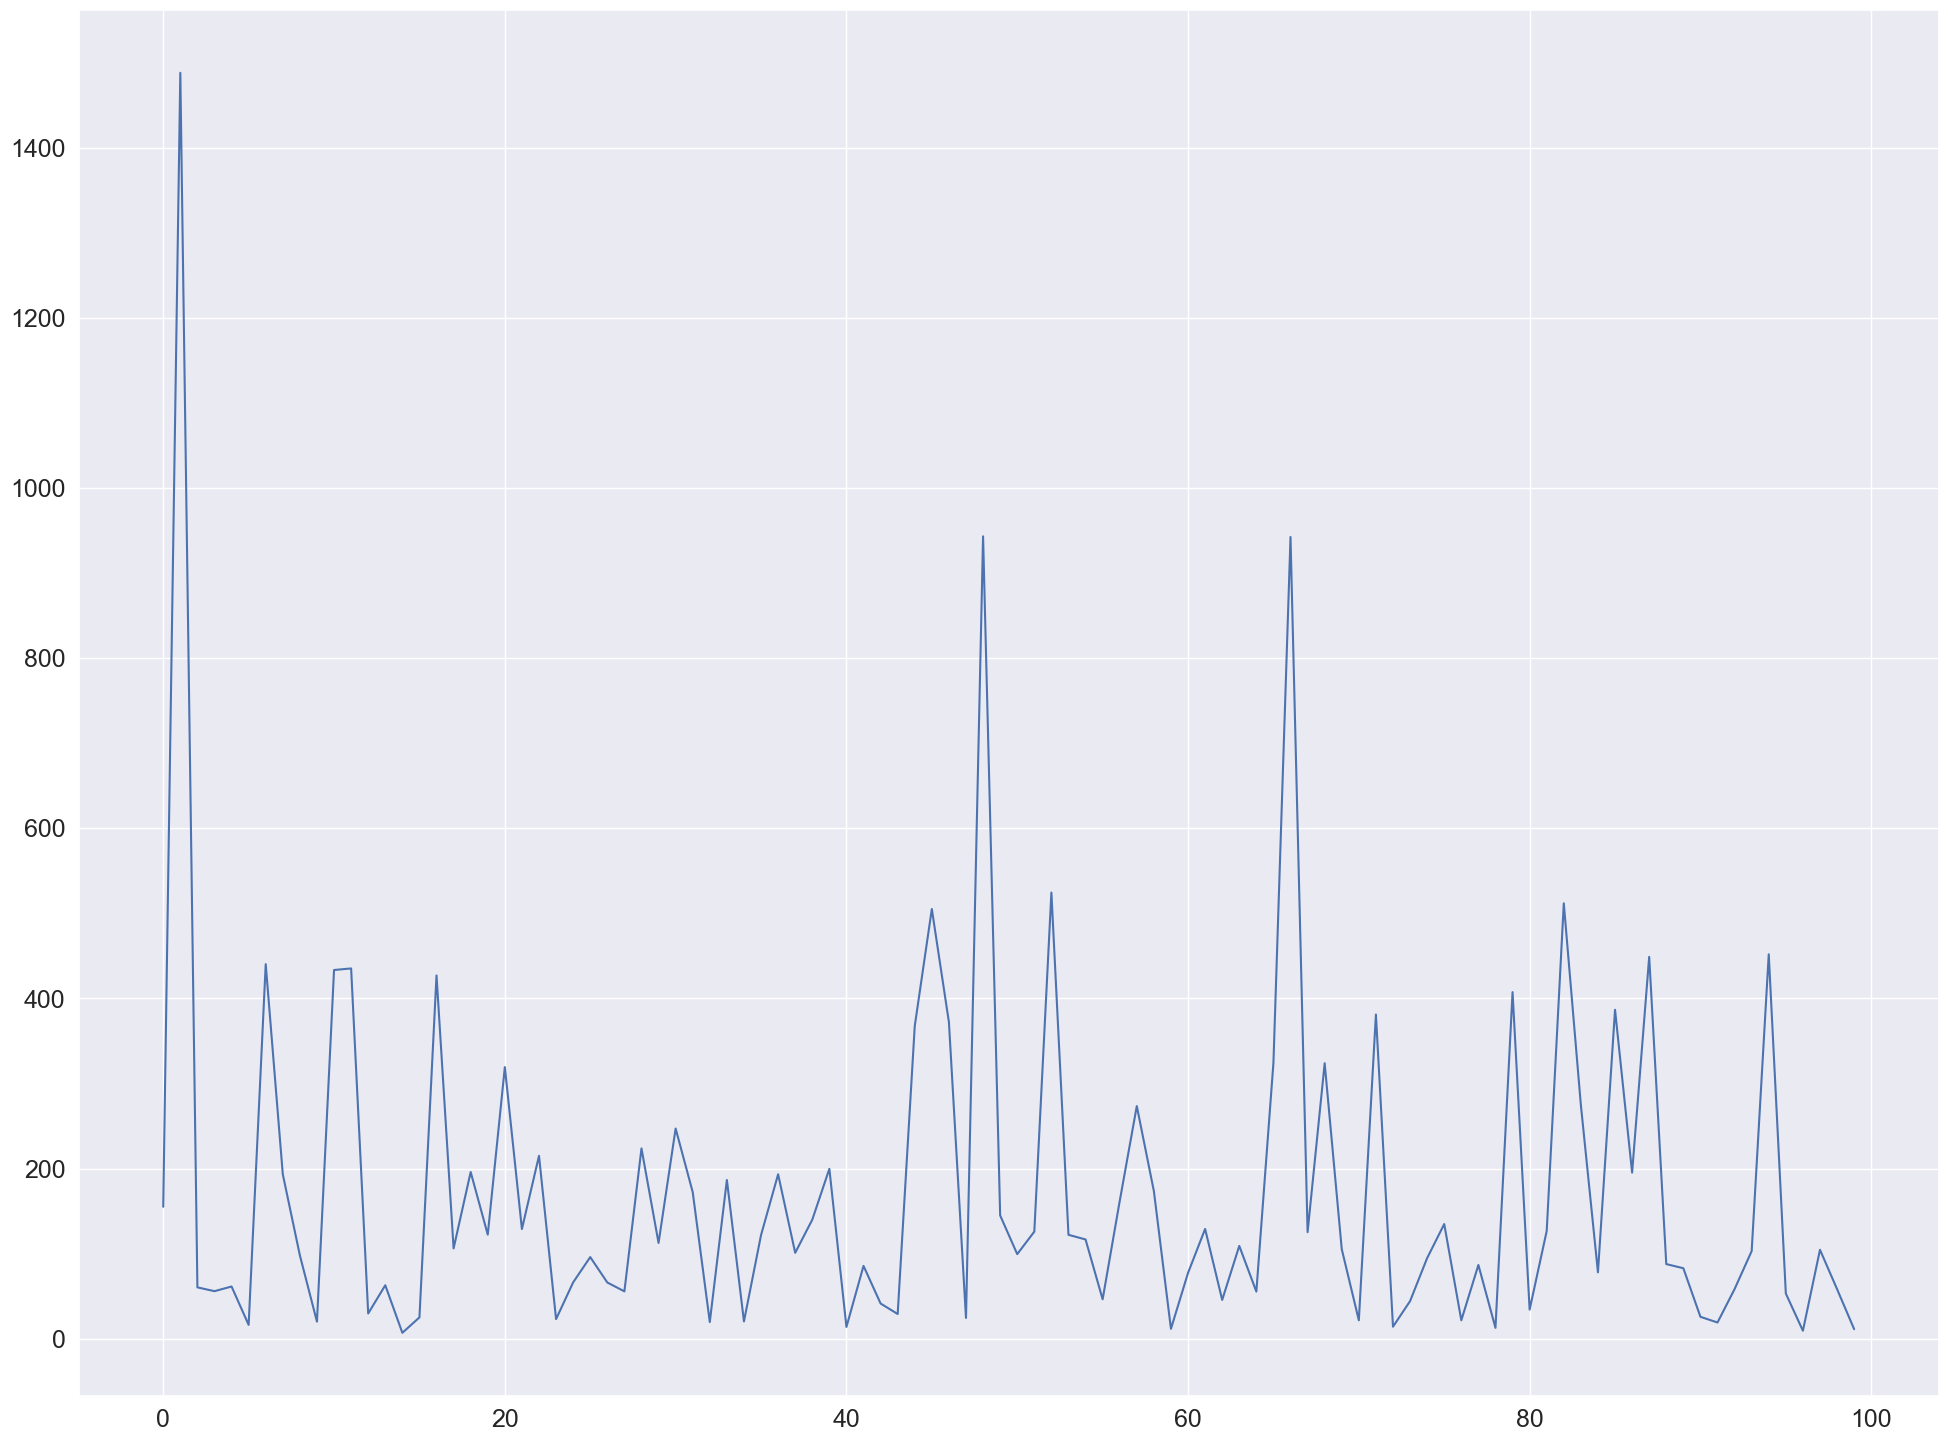

In [9]:
total_loss_list=[]
for i in result:
    total_loss_list.append(i[-1].detach().cpu().numpy())
plt.plot(total_loss_list)

In [10]:
result_std=torch.zeros((5,100))
for i in range(len(result)):
    result_std[0,i]=result[i][0].item()
    result_std[1,i]=result[i][1].item()
    result_std[2,i]=result[i][2].item()
    result_std[3,i]=result[i][3].item()
    result_std[4,i]=result[i][4].item()

In [11]:
result_std.std(dim=1)

tensor([  4.2886,   3.9855,  11.5619,  58.0950, 166.2698])